/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/2s/t87m92j14g9b1yw35n324r5w0000gn/T/ipykernel_29887/291391632.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to constr

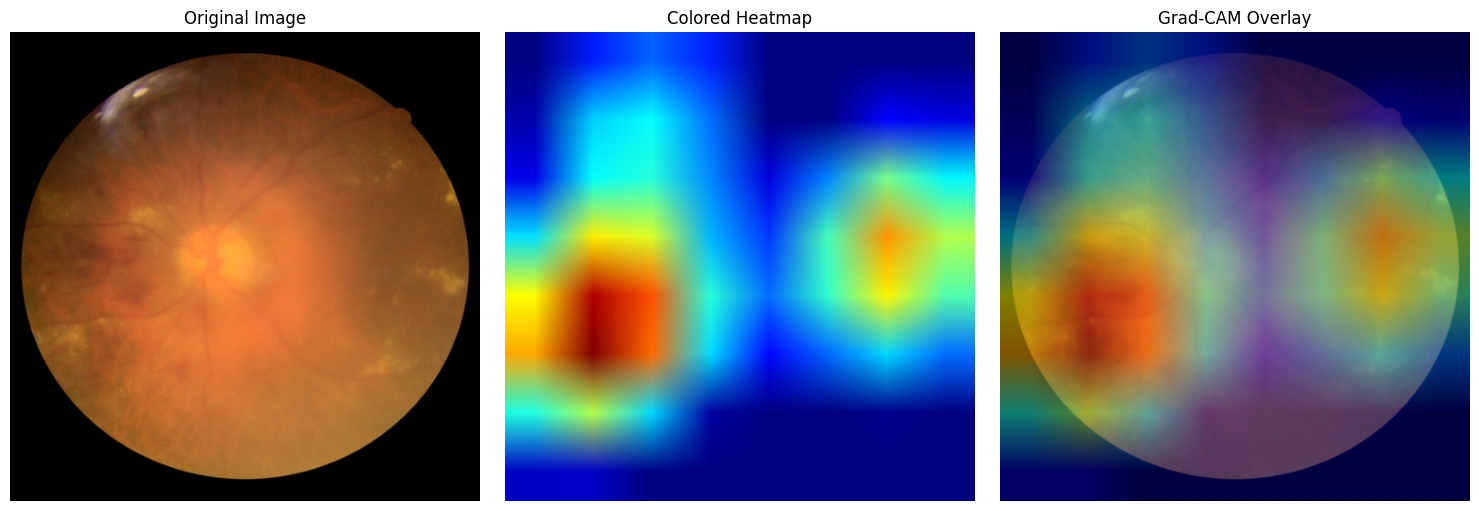

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the ResNet-18 model with the custom head
class Resnet_18(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

# Grad-CAM Helper Class (same as before)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradients = None

        # Register hooks to capture features and gradients
        self.target_layer.register_forward_hook(self.save_features)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_features(self, module, input, output):
        self.feature_maps = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
        # Average the gradients across the channels
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Compute weighted sum of feature maps
        heatmap = torch.sum(weights * self.feature_maps, dim=1).squeeze()

        # ReLU to remove negative values
        heatmap = F.relu(heatmap)

        # Normalize the heatmap to [0, 1]
        heatmap = heatmap - heatmap.min()
        heatmap = heatmap / heatmap.max()
        return heatmap.cpu().detach().numpy()

# Define image transformations
image_size = 256
transform = transforms.Compose([
    transforms.Resize(image_size, antialias=True),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Function to visualize Grad-CAM heatmaps (same as before)
def visualize_gradcam(heatmap, original_image):
    # Scale the heatmap to 0-255
    heatmap = np.uint8(heatmap * 255)

    # Apply a colormap to make it colorful
    colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert the original image to a NumPy array (ensure it's in RGB)
    original_image = np.asarray(original_image)
    
    # Convert the original image to RGB if it's in BGR
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match the original image size
    colored_heatmap = cv2.resize(colored_heatmap, (original_image_rgb.shape[1], original_image_rgb.shape[0]))

    # Overlay the heatmap on the original image
    overlay = 0.5 * original_image_rgb + 0.5 * colored_heatmap
    overlay = np.uint8(overlay)

    return original_image, colored_heatmap, overlay

# Load the ResNet-18 model
resnet18_model = Resnet_18(num_classes=5)
sd = '/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/results/ensemble_models/res18.pth'
sd_load = torch.load(sd, map_location='cpu')
resnet18_model.load_state_dict(sd_load)
resnet18_model.eval()


# Identify the last convolutional layer (last layer of layer4)
last_conv_layer = resnet18_model.backbone.layer4[-1].conv2  # Last convolution in the last residual block

# Initialize Grad-CAM
grad_cam = GradCAM(resnet18_model, last_conv_layer)

# Load the image
img_path =  "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/DeepDRiD/val/265/265_l1.jpg"
image = Image.open(img_path).convert("RGB")

# Apply transformations
img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Forward pass
output = resnet18_model(img_tensor)
predicted_class = output.argmax(dim=1).item()

# Backward pass for Grad-CAM
resnet18_model.zero_grad()
output[:, predicted_class].backward()

# Generate heatmap
heatmap = grad_cam.generate_heatmap(predicted_class)

# Visualize the Grad-CAM result
original_image_rgb, colored_heatmap, overlay = visualize_gradcam(heatmap, image)

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Colored Heatmap")
plt.imshow(cv2.cvtColor(colored_heatmap, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Grad-CAM Overlay")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
plt.axis('off')

plt.tight_layout()
plt.show()


/var/folders/2s/t87m92j14g9b1yw35n324r5w0000gn/T/ipykernel_29887/291391632.py:79: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(heatmap * 255)


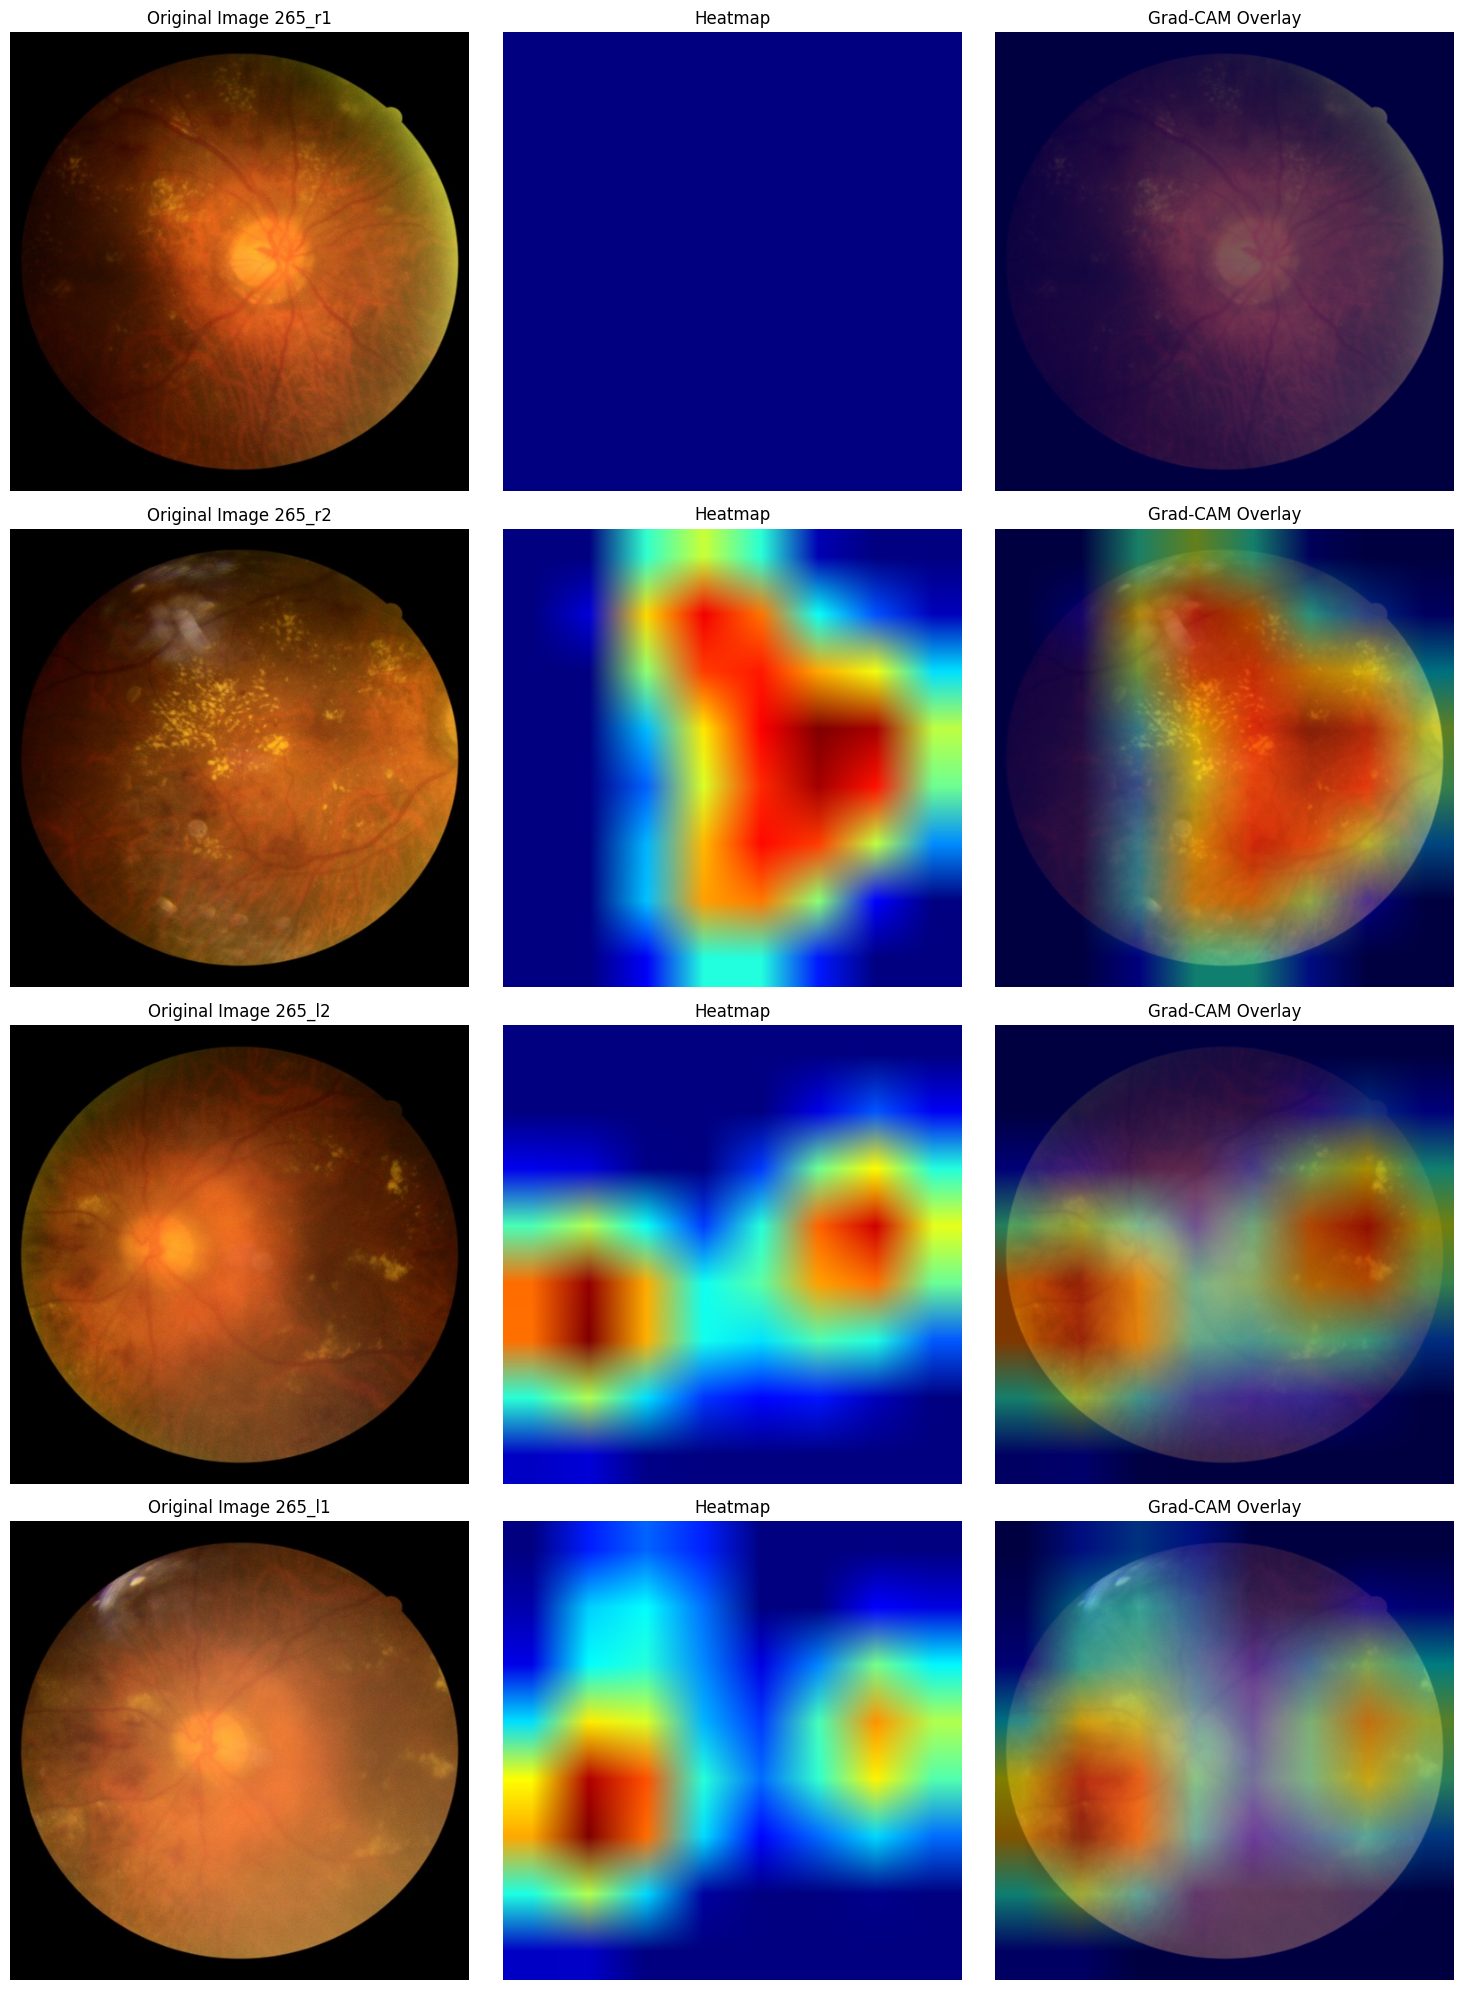

In [2]:
import os

# Set the image directory path
img_dir = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/DeepDRiD/val/265"


#imag titles
img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
image_titles = [os.path.splitext(f)[0] for f in img_files]

# List all image files in the directory
img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

# Number of rows and columns for the plot
num_rows = 4
num_cols = 3

# Create a plot
plt.figure(figsize=(15, 20))

# Iterate over images and plot them
for i, img_file in enumerate(img_files[:num_rows * num_cols]):  # Limit to 12 images
    img_path = os.path.join(img_dir, img_file)
    image = Image.open(img_path).convert("RGB")
    
    # Apply transformations
    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Forward pass
    output = resnet18_model(img_tensor)
    predicted_class = output.argmax(dim=1).item()

    # Backward pass for Grad-CAM
    resnet18_model.zero_grad()
    output[:, predicted_class].backward()

    # Generate heatmap
    heatmap = grad_cam.generate_heatmap(predicted_class)

    # Visualize the Grad-CAM result
    original_image_rgb, colored_heatmap, overlay = visualize_gradcam(heatmap, image)

    # Plot each image in the grid
    row = i // num_cols
    col = i % num_cols

    # Plot original image
    plt.subplot(num_rows, num_cols, i * 3 + 1)
    plt.title(f"Original Image {image_titles[i]}")
    plt.imshow(original_image_rgb)
    plt.axis('off')

    # Plot heatmap
    plt.subplot(num_rows, num_cols, i * 3 + 2)
    plt.title(f"Heatmap")
    plt.imshow(cv2.cvtColor(colored_heatmap, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.axis('off')

    # Plot Grad-CAM overlay
    plt.subplot(num_rows, num_cols, i * 3 + 3)
    plt.title(f"Grad-CAM Overlay")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.axis('off')

# Show the grid of images
plt.tight_layout()
plt.show()


### RES 34

In [3]:
class Resnet_34(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet34(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x
    

resnet18_model = Resnet_34(num_classes=5)
sd = '/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/results/ensemble_models/res34.pth'
sd_load = torch.load(sd, map_location='cpu')
resnet18_model.load_state_dict(sd_load)
resnet18_model.eval()


/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/2s/t87m92j14g9b1yw35n324r5w0000gn/T/ipykernel_29887/1163579992.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the funct

Resnet_34(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

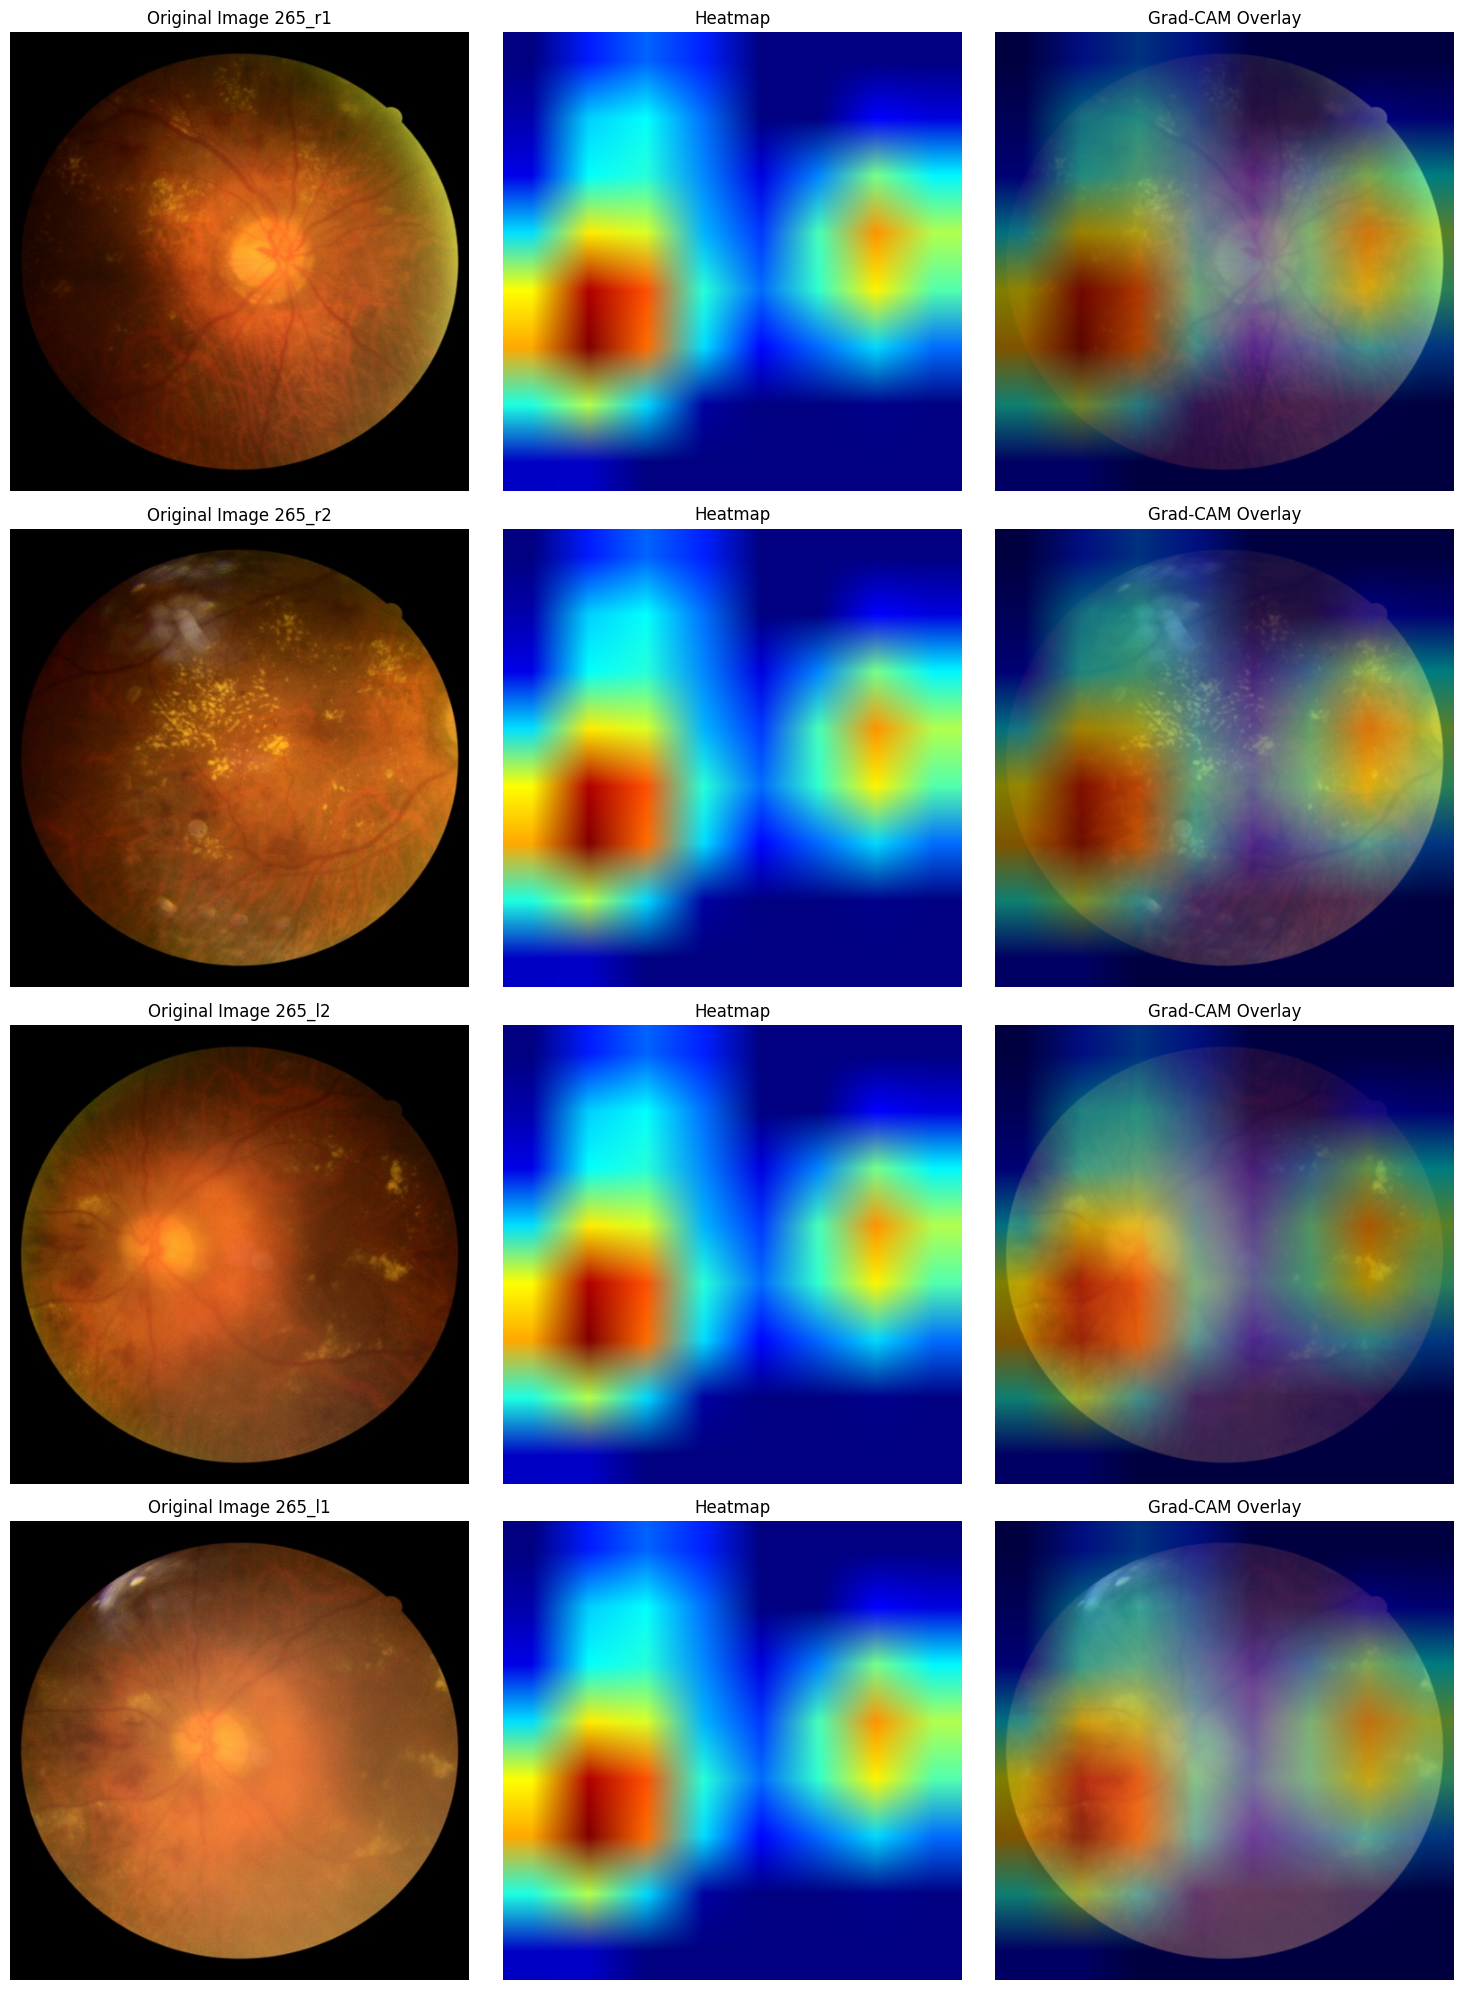

In [4]:
import os

# Set the image directory path
img_dir = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/DeepDRiD/val/265"


#imag titles
img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
image_titles = [os.path.splitext(f)[0] for f in img_files]

# List all image files in the directory
img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

# Number of rows and columns for the plot
num_rows = 4
num_cols = 3

# Create a plot
plt.figure(figsize=(15, 20))

# Iterate over images and plot them
for i, img_file in enumerate(img_files[:num_rows * num_cols]):  # Limit to 12 images
    img_path = os.path.join(img_dir, img_file)
    image = Image.open(img_path).convert("RGB")
    
    # Apply transformations
    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Forward pass
    output = resnet18_model(img_tensor)
    predicted_class = output.argmax(dim=1).item()

    # Backward pass for Grad-CAM
    resnet18_model.zero_grad()
    output[:, predicted_class].backward()

    # Generate heatmap
    heatmap = grad_cam.generate_heatmap(predicted_class)

    # Visualize the Grad-CAM result
    original_image_rgb, colored_heatmap, overlay = visualize_gradcam(heatmap, image)

    # Plot each image in the grid
    row = i // num_cols
    col = i % num_cols

    # Plot original image
    plt.subplot(num_rows, num_cols, i * 3 + 1)
    plt.title(f"Original Image {image_titles[i]}")
    plt.imshow(original_image_rgb)
    plt.axis('off')

    # Plot heatmap
    plt.subplot(num_rows, num_cols, i * 3 + 2)
    plt.title(f"Heatmap")
    plt.imshow(cv2.cvtColor(colored_heatmap, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.axis('off')

    # Plot Grad-CAM overlay
    plt.subplot(num_rows, num_cols, i * 3 + 3)
    plt.title(f"Grad-CAM Overlay")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.axis('off')

# Show the grid of images
plt.tight_layout()
plt.show()
